Each team will develop a machine learning model using those available in `scikit-learn` to predict whether or not a particular will elect to stop services provided by a financial institution based on known attributes. The first five rows of the training data are shown below.

In [52]:
import json
import pathlib
import warnings
import joblib
warnings.filterwarnings("ignore")
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = pd.read_csv('train.csv')
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,597,Germany,Female,35,8,131101.04,1,1,1,192852.67,0
1,523,France,Female,40,2,102967.41,1,1,0,128702.10,1
2,706,Spain,Female,42,8,95386.82,1,1,1,75732.25,0
3,788,France,Male,32,4,112079.58,1,0,0,89368.59,0
4,706,Germany,Male,38,5,163034.82,2,1,1,135662.17,0


Each team will deploy there models to Azure. Specifically, each team should use `Flask` to deploy a web service that can accept JSON payloads via a `post` request. An example of a typical JSON payload that should be expected is shown below.

In [53]:
target = 'Exited'
features = [col for col in data.columns if col != target]

data[features].loc[0].to_dict()

{'CreditScore': 597,
 'Geography': 'Germany',
 'Gender': 'Female',
 'Age': 35,
 'Tenure': 8,
 'Balance': 131101.04,
 'NumOfProducts': 1,
 'HasCrCard': 1,
 'IsActiveMember': 1,
 'EstimatedSalary': 192852.67}

**This will be a graded assignment!** Points will be allocated as follows:
- 70 points for a working deployment
- 20 points for a model that achieves a predictive accuracy greater than 80%.
- 10 points based on competition

The model competition will take place on Monday, 2/21. Each model will be asked to make predictions for > 30 unseen customers. The winning model will be the one that achieves the **highest predictive accuracy**. Teams with the **best and worst** performing models will give a overview of their modeling pipeline (all teams should be prepared to speak to this). This overview should include discussions on:
- data preparation steps,
- model selection, and
- model tuning.

In [54]:
data.shape

(9970, 11)

In [55]:
data.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [56]:
dummy_column_mapper = {}
for col in data.columns:
    if data[col].dtype == 'object':
        temp = pd.get_dummies(data[col], prefix=col, drop_first=True)
        data = data.drop(columns=[col])
        data[temp.columns] = temp
        
with open('dummy_column_mapper.json', 'w') as fout:
    json.dump(dummy_column_mapper, fout)

with open('col_order.json', 'w') as fout:
    json.dump(data.columns.tolist(), fout)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,597,35,8,131101.04,1,1,1,192852.67,0,1,0,0
1,523,40,2,102967.41,1,1,0,128702.10,1,0,0,0
2,706,42,8,95386.82,1,1,1,75732.25,0,0,1,0
3,788,32,4,112079.58,1,0,0,89368.59,0,0,0,1
4,706,38,5,163034.82,2,1,1,135662.17,0,1,0,1


In [57]:
data.shape

(9970, 12)

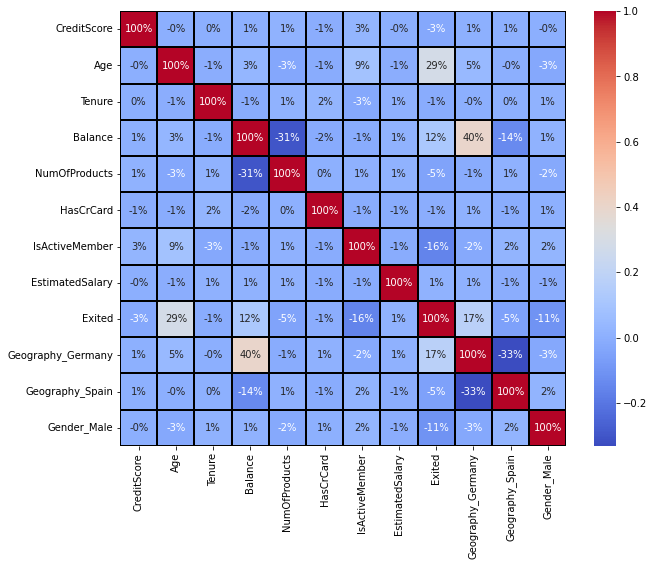

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(
    data.corr(),
    cmap='coolwarm',
    linewidths=0.1,
    linecolor='k',
    annot=True,
    fmt='.0%',
)

plt.show()

Everything looks to be within managable correlation values. 

In [59]:
data.describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,9970.00,9970.00,9970.00,9970.00,9970.00,9970.00,9970.00,9970.00,9970.0,9970.00,9970.00,9970.00
mean,650.58,38.93,5.01,76485.46,1.53,0.71,0.52,100069.88,0.2,0.25,0.25,0.55
std,96.64,10.49,2.89,62400.28,0.58,0.46,0.50,57510.56,0.4,0.43,0.43,0.50
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0,0.00,0.00,0.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,50983.75,0.0,0.00,0.00,0.00
50%,652.00,37.00,5.00,97221.52,1.00,1.00,1.00,100168.24,0.0,0.00,0.00,1.00
75%,718.00,44.00,7.00,127653.82,2.00,1.00,1.00,149395.88,0.0,1.00,0.00,1.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0,1.00,1.00,1.00


In [60]:
target = 'Exited'
features = [col for col in data.columns if col != target]
binary_columns = [col for col in features if sorted(data[col].unique().tolist()) == [0, 1]]

X = data[features].copy()
y = data[target]

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=42,
)

In [63]:
from sklearn.preprocessing import StandardScaler

In [64]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

In [65]:
scaler.mean_

array([6.51235790e+02, 3.89621506e+01, 5.02741741e+00, 7.65272715e+04,
       1.53216531e+00, 7.05764344e-01, 5.16383576e-01, 9.95155279e+04,
       2.50501538e-01, 2.46489234e-01, 5.48348268e-01])

In [66]:
scaler.scale_

array([9.63705132e+01, 1.05618306e+01, 2.89810413e+00, 6.25305376e+04,
       5.83018833e-01, 4.55698403e-01, 4.99731506e-01, 5.75462132e+04,
       4.33301878e-01, 4.30966694e-01, 4.97656955e-01])

In [67]:
X_train['Age'].mean()

38.962150595158484

In [68]:
X_train['Age'].std()

10.562536949691307

In [69]:
scaler_filepath = pathlib.Path('scaler_info.json')

scaler_dict  = {}
for feature, mean, scale in zip(features, scaler.mean_, scaler.scale_):
    if feature in binary_columns:
        scaler_dict[feature] = {
            'mean': 0,
            'std': 1,
        }
    else:
        scaler_dict[feature] = {
            'mean': mean,
            'std': scale,
        }
        
with open(scaler_filepath, 'w') as fout:
    json.dump(scaler_dict, fout)

In [70]:
# apply scaling to all rows and columns in train and test data 
for col, col_params in scaler_dict.items():
    X_train.loc[:, col] = (X_train.loc[:, col] - col_params['mean'])/col_params['std']
    X_test.loc[:, col] = (X_test.loc[:, col] - col_params['mean'])/col_params['std']

In [71]:
round(X_train['Age'].mean(), 2)

0.0

In [72]:
round(X_train['Age'].std(), 2)

1.0

In [73]:
round(X_test['Age'].mean(), 2)

-0.01

In [74]:
round(X_test['Age'].std(), 2)

0.97

# Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression 

clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
logistic_score = clf.score(X_train, y_train)
logistic_score

0.8104854888324194

In [76]:
clf.predict(X_test)[:5]

array([0, 1, 0, 0, 0], dtype=int64)

In [77]:
clf.predict_proba(X_test)[:5]

array([[0.97630164, 0.02369836],
       [0.45538848, 0.54461152],
       [0.8594026 , 0.1405974 ],
       [0.93781543, 0.06218457],
       [0.73431169, 0.26568831]])

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

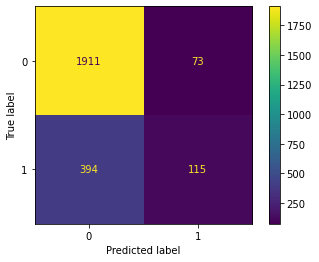

In [79]:
predictions = (clf.predict_proba(X_test)[:, 1] >= .5).astype(int)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_,
)


disp.plot()
plt.show()

In [80]:
model_scores = {}
model_scores['logistic regression']= {'score': logistic_score}
model_scores
joblib.dump(clf, 'log_model.joblib')

['log_model.joblib']

# Decision Tree 

In [81]:
from sklearn import tree 
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
decision_tree = clf.score(X_test, y_test)

In [82]:
model_scores['Decision Tree'] = {'score': decision_tree}

In [83]:
from sklearn.model_selection import GridSearchCV

### Decision Tree Parameters
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [84]:
# Find the parameters that provide the best score for a decision tree
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    # randomly choose to iterate using odd numbers 
    'max_depth': [3,5,7,9,11],
}

clf = GridSearchCV(tree.DecisionTreeClassifier(random_state = 0), params, error_score = 0)
search = clf.fit(X_train, y_train)
decision_tree_best_params = search.best_params_
decision_tree_best_params

{'criterion': 'gini', 'max_depth': 7, 'splitter': 'random'}

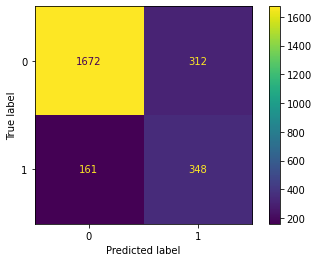

In [85]:
clf = tree.DecisionTreeClassifier(random_state = 0, **decision_tree_best_params)
clf = clf.fit(X_train, y_train)
decision_tree_gridsearch = clf.score(X_test, y_test)
predictions = (clf.predict_proba(X_test)[:, 1] >= .25).astype(int)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_,
)
disp.plot()
plt.show()

In [86]:
model_scores['Decision Tree GridSearch'] = {'score': decision_tree_gridsearch, 'best parameters': decision_tree_best_params}

In [87]:
joblib.dump(clf, 'tree_model.joblib')
model_scores

{'logistic regression': {'score': 0.8104854888324194},
 'Decision Tree': {'score': 0.7813878860810268},
 'Decision Tree GridSearch': {'score': 0.8640192539109507,
  'best parameters': {'criterion': 'gini',
   'max_depth': 7,
   'splitter': 'random'}}}

# Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
with open('model_scores.json') as json_file:
    model_scores = json.load(json_file)

### Random Foest Parameters 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [90]:
model_scores

{'logistic regression': {'score': 0.8104854888324194},
 'Decision Tree': {'score': 0.7866024869634978},
 'Decision Tree GridSearch': {'score': 0.8640192539109507,
  'best parameters': {'criterion': 'gini',
   'max_depth': 7,
   'splitter': 'random'}},
 'Random Forest GridSearch': {'score': 0.8696349779382271,
  'best parameters': {'criterion': 'entropy',
   'max_depth': 11,
   'max_features': 'auto',
   'n_estimators': 100}},
 'Ada Boost GridSearch': {'score': 0.857200160449258,
  'best parameters': {'learning_rate': 0.2, 'n_estimators': 150}},
 'Voting Classifier': {'score': 0.8692338547934216,
  'best parameters': {'voting': 'soft', 'weights': [0.2, 0.8]}}}

In [91]:
# params = {
#     'n_estimators' : [10, 50, 100, 150],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3,5,7,9,11],
#     'max_features': ['auto', 'sqrt', 'log2'],
# }

# clf = GridSearchCV(RandomForestClassifier(random_state = 0), params, error_score = 0)
# search = clf.fit(X_train, y_train)
# best_params = search.best_params_
# best_params

In [92]:
random_forest_best_params = model_scores['Random Forest GridSearch']['best parameters']

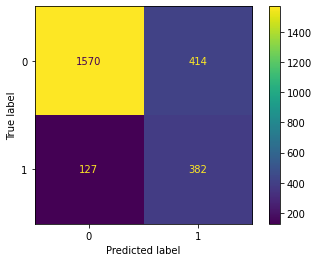

In [93]:
rf_clf = RandomForestClassifier(random_state = 0, **random_forest_best_params)
rf_clf = rf_clf.fit(X_train, y_train)
random_forest_gridsearch = rf_clf.score(X_test, y_test)
predictions = (clf.predict_proba(X_test)[:, 1] >= .2).astype(int)
cm = confusion_matrix(y_test, predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=rf_clf.classes_,
)
disp.plot()
plt.show()

In [94]:
display(random_forest_gridsearch)
display(random_forest_best_params)
model_scores['Random Forest GridSearch'] = {'score': random_forest_gridsearch, 'best parameters': random_forest_best_params}
joblib.dump(rf_clf, 'rf_model.joblib')

0.8696349779382271

{'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 'auto',
 'n_estimators': 100}

['rf_model.joblib']

# AdaBoost Classifier

In [95]:
from sklearn.ensemble import AdaBoostClassifier 

params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'learning_rate': [.1, .15, .20, 0.25, 0.5, .75, 1.0, 2.0],
}    


clf = GridSearchCV(AdaBoostClassifier(random_state=0), params, error_score=0)
search = clf.fit(X_train, y_train)
print(type(search))
best_params = search.best_params_ 

<class 'sklearn.model_selection._search.GridSearchCV'>


In [96]:
adaboost_params = best_params

In [97]:
clf = AdaBoostClassifier(random_state = 0, **adaboost_params)
clf = clf.fit(X_train, y_train)
adaboost_gridsearch = clf.score(X_test, y_test)

display(adaboost_gridsearch)
display(adaboost_params)
model_scores['Ada Boost GridSearch'] = {'score': adaboost_gridsearch, 'best parameters': adaboost_params}
joblib.dump(clf, 'ada_model.joblib')

0.857200160449258

{'learning_rate': 0.2, 'n_estimators': 150}

['ada_model.joblib']

# Voting Classifier

In [98]:
from sklearn.ensemble import VotingClassifier

In [99]:
# Fit Random Forest 
rf_clf = RandomForestClassifier(random_state = 0, **random_forest_best_params)
rf_clf = rf_clf.fit(X_train, y_train)
random_forest_gridsearch = rf_clf.score(X_test, y_test)
print(f'Fitting Random Forest Classifier:', {random_forest_gridsearch})

# Fit Ada Boost 
ada_clf = AdaBoostClassifier(random_state = 0, **adaboost_params)
ada_clf = ada_clf.fit(X_train, y_train)
adaboost_gridsearch = ada_clf.score(X_test, y_test)
print(f'Fitting AdaBoost Classifier:', {adaboost_gridsearch})

params = {
    'voting': ['hard', 'soft'],
    'weights': [[.2,.8], [0.25, 0.75], [0.5, 0.5], [0.75, 0.25], [1,2],[2,1]],
}    

eclf = VotingClassifier(
    estimators=[('rf', rf_clf), ('ada', ada_clf)], 
)

vc_clf = GridSearchCV(eclf, params, error_score=0)
search = vc_clf.fit(X_train, y_train)
vc_params = search.best_params_ 



eclf = VotingClassifier(
    estimators=[('rf', rf_clf), ('ada', ada_clf)],
    **vc_params,
)


eclf = eclf.fit(X_train, y_train)
vc_gridsearch = eclf.score(X_test, y_test)
model_scores['Voting Classifier'] = {'score': vc_gridsearch, 'best parameters' : vc_params}
joblib.dump(vc_clf, 'vote_model.joblib')

Fitting Random Forest Classifier: {0.8696349779382271}
Fitting AdaBoost Classifier: {0.857200160449258}


['vote_model.joblib']

In [100]:
print(vc_params)
print(f'Fitting Voting Classifier:', {vc_gridsearch})

{'voting': 'soft', 'weights': [0.2, 0.8]}
Fitting Voting Classifier: {0.8692338547934216}


### Save model scores dictionary to json file for ease of access 

In [101]:
model_scores_filepath = pathlib.Path('model_scores.json')
        
with open(model_scores_filepath, 'w') as fout:
    json.dump(model_scores, fout)

In [102]:
model_scores

{'logistic regression': {'score': 0.8104854888324194},
 'Decision Tree': {'score': 0.7866024869634978},
 'Decision Tree GridSearch': {'score': 0.8640192539109507,
  'best parameters': {'criterion': 'gini',
   'max_depth': 7,
   'splitter': 'random'}},
 'Random Forest GridSearch': {'score': 0.8696349779382271,
  'best parameters': {'criterion': 'entropy',
   'max_depth': 11,
   'max_features': 'auto',
   'n_estimators': 100}},
 'Ada Boost GridSearch': {'score': 0.857200160449258,
  'best parameters': {'learning_rate': 0.2, 'n_estimators': 150}},
 'Voting Classifier': {'score': 0.8692338547934216,
  'best parameters': {'voting': 'soft', 'weights': [0.2, 0.8]}}}